In [268]:
import sys

sys.path.append(
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages"
)

import biolib
import gzip
import math
import os
import requests
import tspex

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xml.etree.ElementTree as ET

from io import StringIO
from IPython.display import Image
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [269]:
ALL_FASTA_OUTPUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\all_fasta.fasta"
ALL_TARGETS_OUTPUT_DIRECTORY = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_all_targets"
)

ASSAY_LIST_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\assay-list-olink-explore-3072.xlsx"
)
BRAIN_RNA_SEQ_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\brain_rna_seq.csv"
HGNC_IDS = (
    "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
)
MICROGLIA_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\microglia_fasta.fasta"
)
MATURE_ASTROCYTE_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\mature_astrocyte_fasta.fasta"
)
OLIGODENDROCYTE_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\oligodendrocyte_fasta.fasta"
)
PLATE_LAYOUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\Plate Layout.xlsx"


RAW_DATA_FILE = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\LCSET_28343_10-4-2023_EXTENDED_NPX_2023-10-20.csv"
TMHMM_OUTPUT = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_all_targets\\TMRs.gff3"
)
UNIPROT_TO_FASTA_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\uniprotkb_proteome_UP000005640_2023_11_20.fasta.gz"


PANELS = [
    "Cardiometabolic",
    "Cardiometabolic_II",
    "Inflammation",
    "Inflammation_II",
    "Neurology",
    "Neurology_II",
    "Oncology",
    "Oncology_II",
]


UNIMPORTANT_COLUMNS = [
    "Index",
    "OlinkID",
    "Panel_Lot_Nr",
    "PlateID",
    "WellID",
    "Normalization",
    "Processing_StartDate",
    "Processing_EndDate",
    "AnalyzerID",
    "ExploreVersion",
]


X_AXIS_ORDER = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV",
    "Plas A Internal EV",
    "Plas B Internal EV",
    "Plas C Internal EV",
    "Plasma D Internal EV",
]

CSF_SAMPLES = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV",
]

In [270]:
assay_list = pd.read_excel(ASSAY_LIST_PATH)


# Map UniProt IDs to the corresponding FASTA sequences
def parse_gz_file(file_path):
    protein_dict = {}
    current_uniprot_id = None
    current_sequence = ""
    with gzip.open(file_path, "rt") as f:
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if current_uniprot_id is not None:
                    protein_dict[current_uniprot_id] = current_sequence
                    current_sequence = ""
                if "|" in line:
                    current_uniprot_id = line.split("|")[1].strip()
                else:
                    print(f"Skipping line without expected format: {line}")
                    current_uniprot_id = None
            else:
                current_sequence += line
        if current_uniprot_id is not None:
            protein_dict[current_uniprot_id] = current_sequence
    return protein_dict

protein_data = parse_gz_file(UNIPROT_TO_FASTA_PATH)

assay_list["Sequence"] = assay_list["UniProt ID"].map(
    lambda x: protein_data.get(x, "N/A")
)

In [271]:
# # Create a FASTA file containing the information for the OLINK targets

# def export_fasta(output_path, df):
#     with open(output_path, "w") as output_file:
#         for index, row in df.iterrows():
#             output_file.write(f">{row["UniProt ID"]}\n")
#             output_file.write(f"{row["Sequence"]}\n")
# export_fasta(ALL_FASTA_OUTPUT_PATH, assay_list)

# # Use the TMHMM deep learning model to predict the localication of each of the OLINK targets
# deeptmhmm = biolib.load("DTU/DeepTMHMM")
# def tmhmm_localization(targets, output_directory):
#     if not os.path.exists(output_directory):
#         os.makedirs(output_directory)
#     os.chdir(output_directory)
#     with open("query.fasta", "w") as fasta_file:
#         for _, row in targets.iterrows():
#             sequence = row["Sequence"]
#             uniprot_id = row["UniProt ID"]
#             fasta_line = f">{uniprot_id}\n{sequence}\n"
#             fasta_file.write(fasta_line)
#         biolib.utils.STREAM_STDOUT = True
#         deeptmhmm_job = deeptmhmm.cli(
#             args="--fasta query.fasta", machine="local"
#         )
#         deeptmhmm_job.save_files(output_directory)

# tmhmm_localization(assay_list, ALL_TARGETS_OUTPUT_DIRECTORY)

In [272]:
# Import the TMHMM output
with open(TMHMM_OUTPUT, "r") as gff_file:
    gff_lines = gff_file.readlines()

# Create lists to store data
uniprot_ids = []
region_locations = []
region_starts = []
region_ends = []

# Extract data from the GFF file produced by TMHMM
for line in gff_lines:
    if not line.startswith("//"):
        columns = line.strip().split("\t")
        if len(columns) >= 4:
            uniprot_id = columns[0]
            region_location = columns[1]
            region_start = int(columns[2])
            region_end = int(columns[3])

            uniprot_ids.append(uniprot_id)
            region_locations.append(region_location)
            region_starts.append(region_start)
            region_ends.append(region_end)

# Create a new dataframe
data = {
    "UniProt ID": uniprot_ids,
    "Region Location": region_locations,
    "Region Start": region_starts,
    "Region End": region_ends,
}

tmhmm_df = pd.DataFrame(data)

tm_tmhmm = tmhmm_df[tmhmm_df["Region Location"] == "TMhelix"]
outside_tmhmm = tmhmm_df[tmhmm_df["Region Location"] == "outside"]
inside_tmhmm = tmhmm_df[tmhmm_df["Region Location"] == "inside"]

tm_uniprots = set(tm_tmhmm["UniProt ID"])
inside_uniprots = set(inside_tmhmm["UniProt ID"])
outside_uniprots = set(outside_tmhmm["UniProt ID"])

inside_uniprots = inside_uniprots - tm_uniprots - outside_uniprots
outside_uniprots = outside_uniprots - tm_uniprots - inside_uniprots

Text(0.5, 1.0, 'OLINK Target Localization')

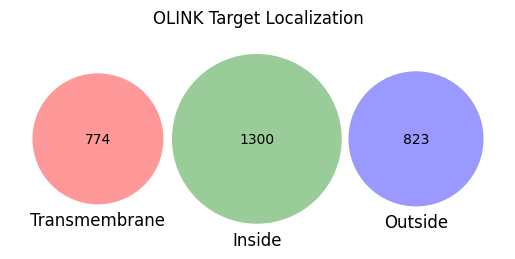

In [273]:
venn3(
    [tm_uniprots, inside_uniprots, outside_uniprots],
    set_labels = ("Transmembrane", "Inside", "Outside")
)
plt.title("OLINK Target Localization")

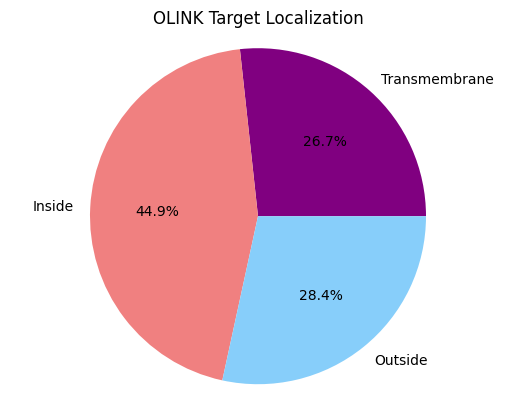

In [274]:
# Data to plot
labels = ["Transmembrane", "Inside", "Outside"]
sizes = [774, 1300, 823]
colors = ['purple', 'lightcoral', 'lightskyblue']

# Plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("OLINK Target Localization")
plt.show()

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_9232\3299882544.py:92: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x="variable", y="value", inner=None, scale="count", color='C0',


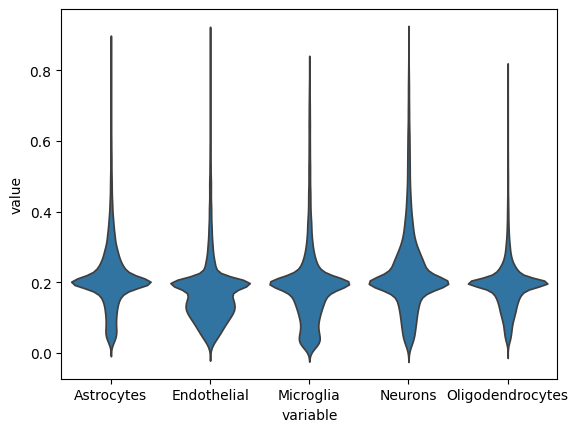

In [275]:
# Define necessary functions and import files
def calculate_mean(df):
    return df.assign(Mean=df.mean(axis=1, numeric_only=True))

brain_rna_seq = pd.read_csv(BRAIN_RNA_SEQ_PATH)

# Map the HGNC IDs to the UniProt IDs
# This database that maps HGNC IDs to UniProt IDs doesn"t have all the UniProt IDs we need, resulting in some targets being dropped unnecessarily
response = requests.get(HGNC_IDS)
content = response.text
file_like_object = StringIO(content)
uniprot_ids = pd.read_csv(file_like_object, sep="\t", low_memory=False)

brain_rna_seq = pd.merge(brain_rna_seq, uniprot_ids, left_on = "id", right_on = "hgnc_id", how = "inner")

# Find the mean expression of each cell type 
mature_astrocytes_cols = [
    "gene_id",
    "id",
    "uniprot_ids",
    "astrocytes_mature_1",
    "astrocytes_mature_2",
    "astrocytes_mature_3",
    "astrocytes_mature_4",
    "astrocytes_mature_5",
    "astrocytes_mature_6",
    "astrocytes_mature_7",
    "astrocytes_mature_8",
    "astrocytes_mature_9",
    "astrocytes_mature_10",
    "astrocytes_mature_11",
    "astrocytes_mature_12",
]
mature_astrocytes = brain_rna_seq[mature_astrocytes_cols]

endothelial_cols = ["gene_id", "id", "uniprot_ids", "endothelial_1", "endothelial_2"]
endothelial = brain_rna_seq[endothelial_cols]

microglia_cols = ["gene_id", "id", "uniprot_ids", "microglla_1", "microglla_2", "microglla_3"]
microglia = brain_rna_seq[microglia_cols]

oligodendrocyte_cols = [
    "gene_id",
    "id",
    "uniprot_ids",
    "oligodendrocytes_1",
    "oligodendrocytes_2",
    "oligodendrocytes_3",
    "oligodendrocytes_4",
    "oligodendrocytes_5",
]
oligodendrocytes = brain_rna_seq[oligodendrocyte_cols]

neurons_cols = ["gene_id", "id", "uniprot_ids", "neurons_1"]
neurons = brain_rna_seq[neurons_cols]

neurons = calculate_mean(neurons)
oligodendrocytes = calculate_mean(oligodendrocytes)
microglia = calculate_mean(microglia)
endothelial = calculate_mean(endothelial)
mature_astrocytes = calculate_mean(mature_astrocytes)

neurons = neurons[["id", "uniprot_ids", "Mean"]]
oligodendrocytes = oligodendrocytes[["id", "uniprot_ids", "Mean"]]
microglia = microglia[["id", "uniprot_ids", "Mean"]]
endothelial = endothelial[["id", "uniprot_ids", "Mean"]]
mature_astrocytes = mature_astrocytes[["id", "uniprot_ids", "Mean"]]

neurons.rename(columns = {"id": "hgnc_id", "uniprot_ids": "uniprot_id", "Mean": "Neurons"}, inplace = True)
oligodendrocytes.rename(columns = {"id": "hgnc_id", "uniprot_ids": "uniprot_id", "Mean": "Oligodendrocytes"}, inplace = True)
microglia.rename(columns = {"id": "hgnc_id", "uniprot_ids": "uniprot_id", "Mean": "Microglia"}, inplace = True)
endothelial.rename(columns = {"id": "hgnc_id", "uniprot_ids": "uniprot_id", "Mean": "Endothelial"}, inplace = True)
mature_astrocytes.rename(columns = {"id": "hgnc_id", "uniprot_ids": "uniprot_id", "Mean": "Astrocytes"}, inplace = True)

all_cells = pd.merge(neurons, oligodendrocytes, on = "hgnc_id")
all_cells = all_cells[["hgnc_id", "uniprot_id_x", "Neurons", "Oligodendrocytes"]]
all_cells = pd.merge(all_cells, microglia, on = "hgnc_id")
all_cells = all_cells[["hgnc_id", "uniprot_id_x", "Neurons", "Oligodendrocytes", "Microglia"]]
all_cells = pd.merge(all_cells, endothelial, on = "hgnc_id")
all_cells = all_cells[["hgnc_id", "uniprot_id_x", "Neurons", "Oligodendrocytes", "Microglia", "Endothelial"]]
all_cells = pd.merge(all_cells, mature_astrocytes, on = "hgnc_id")
all_cells = all_cells[["hgnc_id", "uniprot_id_x", "Neurons", "Oligodendrocytes", "Microglia", "Endothelial", "Astrocytes"]]

all_cells.drop_duplicates(subset="uniprot_id_x", inplace=True)
all_cells.dropna(subset=["uniprot_id_x"], inplace=True)
all_cells.set_index("uniprot_id_x", inplace = True)

# Determine the tissue specificity of each gene
expression_data = all_cells.loc[:, ["Astrocytes", "Endothelial", "Microglia", "Neurons", "Oligodendrocytes"]]
tso = tspex.TissueSpecificity(expression_data, "tsi", log=True)

sns.violinplot(x="variable", y="value", inner=None, scale="count", color='C0',
               data=tso.tissue_specificity.melt());

expression_data_df = pd.DataFrame(tso.tissue_specificity)

astrocyte_uniprot_ids = expression_data_df[expression_data_df["Astrocytes"] < 0.04].index.tolist()
microglia_uniprot_ids = expression_data_df[expression_data_df["Microglia"] < 0.04].index.tolist()
neuron_uniprot_ids = expression_data_df[expression_data_df["Neurons"] < 0.04].index.tolist()
oligodendrocyte_uniprot_ids = expression_data_df[expression_data_df["Oligodendrocytes"] < 0.04].index.tolist()


In [276]:
import random

In [305]:
random_values = random.sample(astrocyte_uniprot_ids, 1)
print(random_values)

['P10721']


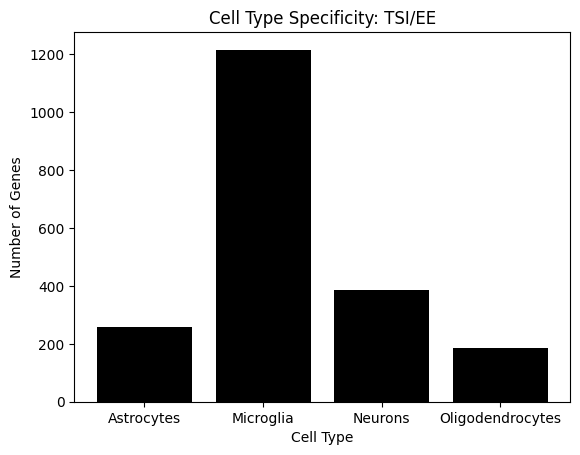

In [278]:
expression_dict = {
    len(astrocyte_uniprot_ids): "Astrocytes",
    len(microglia_uniprot_ids): "Microglia",
    len(neuron_uniprot_ids): "Neurons",
    len(oligodendrocyte_uniprot_ids): "Oligodendrocytes"
}

x_labels = list(expression_dict.values())
y_labels = list(expression_dict.keys())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Cell Type")
plt.ylabel("Number of Genes")
plt.title("Cell Type Specificity: TSI/EE")
plt.show()

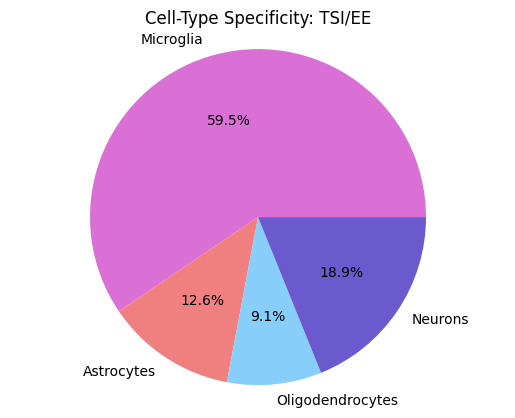

In [279]:
labels = ["Microglia", "Astrocytes", "Oligodendrocytes", "Neurons"]
sizes = [len(microglia_uniprot_ids), len(astrocyte_uniprot_ids), len(oligodendrocyte_uniprot_ids), len(neuron_uniprot_ids)]
colors = ['orchid', 'lightcoral', 'lightskyblue', "slateblue"]

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal') 
plt.title("Cell-Type Specificity: TSI/EE")
plt.show()

In [280]:
# Clean up the raw OLINK data file and map the sample locations to their barcodes
plate_layout = pd.read_excel(PLATE_LAYOUT_PATH, index_col=0)
raw_data = pd.read_csv(RAW_DATA_FILE, sep=";")
raw_data = raw_data.drop(UNIMPORTANT_COLUMNS, axis=1)

data = pd.merge(raw_data, plate_layout, how="left", on="SampleID")

# Normalize the data according to plate negative controls
ctrl_dict = {}
for panel in PANELS:
    df = data[(data["Panel"] == panel)]
    plate_ctrl = df[
        (df["Sample_Type"] == "PLATE_CONTROL")
        & (df["Assay"] == "Amplification control 1")
    ]["NPX"].median()
    ctrl_dict[panel] = plate_ctrl
data["Delta"] = data.apply(
    lambda row: row["NPX"] - ctrl_dict[row["Panel"]],
    axis=1,
)

# Linearize the NPX values
data["Linear Delta"] = data["Delta"].map(lambda x: 2**x)

# Identify and drop replicate assays
vc = data[["SampleID", "Sample_Type", "UniProt"]].value_counts()
vc = vc[vc > 1]

unique_uniprot_values = vc.index.get_level_values("UniProt").unique()
uniprot_list = unique_uniprot_values.tolist()

raw_data_no_reps = data[~data["UniProt"].isin(uniprot_list)].copy()

# Create a tidy dataframe for the delta values
tidy_data = raw_data_no_reps[raw_data_no_reps["Sample_Type"] == "SAMPLE"].pivot(
    columns="UniProt", index=["SampleID", "Health", "Sample"], values="Linear Delta"
)

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_9232\2731001649.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ad_healthy_mannwhitneyu = pd.concat(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_9232\2731001649.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ad_mci_mannwhitneyu = pd.concat(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_9232\2731001649.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this 

Text(0.5, 1.0, 'Assays with Significant Differences Between Samples')

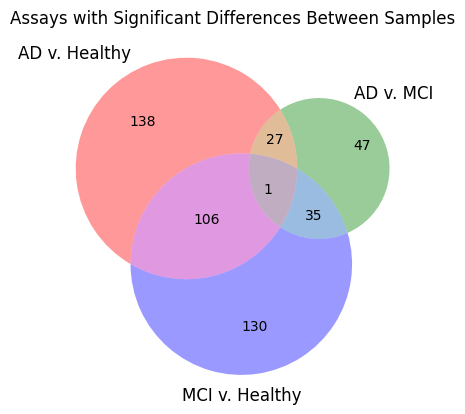

In [281]:
# Mann-Whitney U Test to determine significant difference between AD/MCI/Healthy samples in all fractions

assay_list = list(tidy_data.columns)

healthy_df = tidy_data[tidy_data.index.get_level_values("Health") == "Healthy"]
mci_df = tidy_data[tidy_data.index.get_level_values("Health") == "MCI"]
ad_df = tidy_data[tidy_data.index.get_level_values("Health") == "AD"]

ad_healthy_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
ad_mci_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
mci_healthy_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])

for assay in assay_list:
    healthy_assays = list(healthy_df[assay])
    mci_assays = list(mci_df[assay])
    ad_assays = list(ad_df[assay])

    ad_healthy_statistic, ad_healthy_p_value = mannwhitneyu(ad_assays, healthy_assays)
    ad_mci_statistic, ad_mci_p_value = mannwhitneyu(ad_assays, mci_assays)
    mci_healthy_statistic, mci_healthy_p_value = mannwhitneyu(
        mci_assays, healthy_assays
    )

    ad_healthy_result_row = pd.DataFrame(
        {
            "Assay": [assay],
            "p-value": [ad_healthy_p_value],
            "Statistic": [ad_healthy_statistic],
        }
    )
    ad_mci_result_row = pd.DataFrame(
        {"Assay": [assay], "p-value": [ad_mci_p_value], "Statistic": [ad_mci_statistic]}
    )
    mci_healthy_result_row = pd.DataFrame(
        {
            "Assay": [assay],
            "p-value": [mci_healthy_p_value],
            "Statistic": [mci_healthy_statistic],
        }
    )

    ad_healthy_mannwhitneyu = pd.concat(
        [ad_healthy_mannwhitneyu, ad_healthy_result_row], ignore_index=True
    )
    ad_mci_mannwhitneyu = pd.concat(
        [ad_mci_mannwhitneyu, ad_mci_result_row], ignore_index=True
    )
    mci_healthy_mannwhitneyu = pd.concat(
        [mci_healthy_mannwhitneyu, mci_healthy_result_row], ignore_index=True
    )

ad_healthy_sig_dif = ad_healthy_mannwhitneyu[ad_healthy_mannwhitneyu["p-value"] < 0.05]
ad_mci_sig_dif = ad_mci_mannwhitneyu[ad_mci_mannwhitneyu["p-value"] < 0.05]
mci_healthy_sig_dif = mci_healthy_mannwhitneyu[
    mci_healthy_mannwhitneyu["p-value"] < 0.05
]

ad_healthy_sig_dif_assays = set(ad_healthy_sig_dif["Assay"])
ad_mci_sig_dif_assays = set(ad_mci_sig_dif["Assay"])
mci_healthy_sig_dif_assays = set(mci_healthy_sig_dif["Assay"])

venn3(
    [ad_healthy_sig_dif_assays, ad_mci_sig_dif_assays, mci_healthy_sig_dif_assays],
    set_labels=("AD v. Healthy", "AD v. MCI", "MCI v. Healthy"),
)
plt.title("Assays with Significant Differences Between Samples")

In [282]:
# Mann-Whitney U Test to determine significant difference between AD/MCI/Healthy samples in EV/secreted fractions

assay_list = list(tidy_data.columns)

ad_healthy_ev_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
ad_mci_ev_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
mci_healthy_ev_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])

ad_healthy_secreted_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
ad_mci_secreted_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
mci_healthy_secreted_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])

for assay in assay_list:
    tidy_data_assay = tidy_data[assay]
    if not tidy_data_assay.isna().all():
        healthy_assay_ev_peak = (
            (tidy_data_assay.index.get_level_values("Sample").str.contains("9"))
            | (tidy_data_assay.index.get_level_values("Sample").str.contains("10"))
        ) & (tidy_data_assay.index.get_level_values("Health") == "Healthy")
        mci_assay_ev_peak = (
            (tidy_data_assay.index.get_level_values("Sample").str.contains("9"))
            | (tidy_data_assay.index.get_level_values("Sample").str.contains("10"))
        ) & (tidy_data_assay.index.get_level_values("Health") == "MCI")
        ad_assay_ev_peak = (
            (tidy_data_assay.index.get_level_values("Sample").str.contains("9"))
            | (tidy_data_assay.index.get_level_values("Sample").str.contains("10"))
        ) & (tidy_data_assay.index.get_level_values("Health") == "AD")
        healthy_assay_ev_values = tidy_data_assay.loc[healthy_assay_ev_peak].values
        mci_assay_ev_values = tidy_data_assay.loc[mci_assay_ev_peak].values
        ad_assay_ev_values = tidy_data_assay.loc[ad_assay_ev_peak].values
        if not (np.all(np.isnan(healthy_assay_ev_peak))) or not (np.all(np.isnan(mci_assay_ev_peak))) or not (np.all(np.isnan(ad_assay_ev_peak))):
            ad_healthy_ev_statistic, ad_healthy_ev_p_value = mannwhitneyu(
                ad_assay_ev_values, healthy_assay_ev_values
            )
            ad_mci_ev_statistic, ad_mci_ev_p_value = mannwhitneyu(
                ad_assay_ev_values, mci_assay_ev_values
            )
            mci_healthy_ev_statistic, mci_healthy_ev_p_value = mannwhitneyu(
                mci_assay_ev_values, healthy_assay_ev_values
            )
            ad_healthy_ev_result_row = pd.DataFrame(
                {
                    "Assay": [assay],
                    "p-value": [ad_healthy_ev_p_value],
                    "Statistic": [ad_healthy_ev_statistic],
                }
            )
            ad_mci_ev_result_row = pd.DataFrame(
                {
                    "Assay": [assay],
                    "p-value": [ad_mci_ev_p_value],
                    "Statistic": [ad_mci_ev_statistic],
                }
            )
            mci_healthy_ev_result_row = pd.DataFrame(
                {
                    "Assay": [assay],
                    "p-value": [mci_healthy_ev_p_value],
                    "Statistic": [mci_healthy_ev_statistic],
                }
            )
            ad_healthy_ev_mannwhitneyu = pd.concat(
                [ad_healthy_ev_mannwhitneyu, ad_healthy_ev_result_row], ignore_index=True
            )
            ad_mci_ev_mannwhitneyu = pd.concat(
                [ad_mci_ev_mannwhitneyu, ad_mci_ev_result_row], ignore_index=True
            )
            mci_healthy_ev_mannwhitneyu = pd.concat(
                [mci_healthy_ev_mannwhitneyu, mci_healthy_ev_result_row], ignore_index=True
            )
        healthy_assay_secreted = (
            (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 14")
            | (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 15")
        ) & (tidy_data_assay.index.get_level_values("Health") == "Healthy")
        mci_assay_secreted = (
            (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 14")
            | (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 15")
        ) & (tidy_data_assay.index.get_level_values("Health") == "MCI")
        ad_assay_secreted = (
            (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 14")
            | (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 15")
        ) & (tidy_data_assay.index.get_level_values("Health") == "AD")
        healthy_assay_secreted_values = tidy_data_assay.loc[healthy_assay_secreted].values
        mci_assay_secreted_values = tidy_data_assay.loc[mci_assay_secreted].values
        ad_assay_secreted_values = tidy_data_assay.loc[ad_assay_secreted].values
        if not (np.all(np.isnan(healthy_assay_secreted_values))) or not (np.all(np.isnan(mci_assay_secreted_values))) or not (np.all(np.isnan(ad_assay_secreted_values))):

            ad_healthy_secreted_statistic, ad_healthy_secreted_p_value = mannwhitneyu(
                ad_assay_secreted_values, healthy_assay_secreted_values
            )
            ad_mci_secreted_statistic, ad_mci_secreted_p_value = mannwhitneyu(
                ad_assay_secreted_values, mci_assay_secreted_values
            )
            mci_healthy_secreted_statistic, mci_healthy_secreted_p_value = mannwhitneyu(
                mci_assay_secreted_values, healthy_assay_secreted_values
            )
            ad_healthy_secreted_result_row = pd.DataFrame(
                {
                    "Assay": [assay],
                    "p-value": [ad_healthy_secreted_p_value],
                    "Statistic": [ad_healthy_secreted_statistic],
                }
            )
            ad_mci_secreted_result_row = pd.DataFrame(
                {
                    "Assay": [assay],
                    "p-value": [ad_mci_secreted_p_value],
                    "Statistic": [ad_mci_secreted_statistic],
                }
            )
            mci_healthy_secreted_result_row = pd.DataFrame(
                {
                    "Assay": [assay],
                    "p-value": [mci_healthy_secreted_p_value],
                    "Statistic": [mci_healthy_secreted_statistic],
                }
            )
            ad_healthy_secreted_mannwhitneyu = pd.concat(
                [ad_healthy_secreted_mannwhitneyu, ad_healthy_secreted_result_row],
                ignore_index=True,
            )
            ad_mci_secreted_mannwhitneyu = pd.concat(
                [ad_mci_secreted_mannwhitneyu, ad_mci_secreted_result_row], ignore_index=True
            )
            mci_healthy_secreted_mannwhitneyu = pd.concat(
                [mci_healthy_secreted_mannwhitneyu, mci_healthy_secreted_result_row],
                ignore_index=True,
            )

    ad_healthy_ev_sig_dif = ad_healthy_ev_mannwhitneyu[
        ad_healthy_ev_mannwhitneyu["p-value"] < 0.05
    ]
    ad_mci_ev_sig_dif = ad_mci_ev_mannwhitneyu[ad_mci_ev_mannwhitneyu["p-value"] < 0.05]
    mci_healthy_ev_sig_dif = mci_healthy_ev_mannwhitneyu[
        mci_healthy_ev_mannwhitneyu["p-value"] < 0.05
    ]

    ad_healthy_secreted_sig_dif = ad_healthy_secreted_mannwhitneyu[
        ad_healthy_secreted_mannwhitneyu["p-value"] < 0.05
    ]
    ad_mci_secreted_sig_dif = ad_mci_secreted_mannwhitneyu[
        ad_mci_secreted_mannwhitneyu["p-value"] < 0.05
    ]
    mci_healthy_secreted_sig_dif = mci_healthy_secreted_mannwhitneyu[
        mci_healthy_secreted_mannwhitneyu["p-value"] < 0.05
    ]

ad_healthy_ev_sig_dif_assays = set(ad_healthy_ev_sig_dif["Assay"])
ad_mci_ev_sig_dif_assays = set(ad_mci_ev_sig_dif["Assay"])
mci_healthy_ev_sig_dif_assays = set(mci_healthy_ev_sig_dif["Assay"])

ad_healthy_secreted_sig_dif_assays = set(ad_healthy_secreted_sig_dif["Assay"])
ad_mci_secreted_sig_dif_assays = set(ad_mci_secreted_sig_dif["Assay"])
mci_healthy_secreted_sig_dif_assays = set(mci_healthy_secreted_sig_dif["Assay"])

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_9232\212042774.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ad_healthy_ev_mannwhitneyu = pd.concat(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_9232\212042774.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ad_mci_ev_mannwhitneyu = pd.concat(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_9232\212042774.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, th

Text(0.5, 1.0, 'Assays with Significant Differences in EV Fractions')

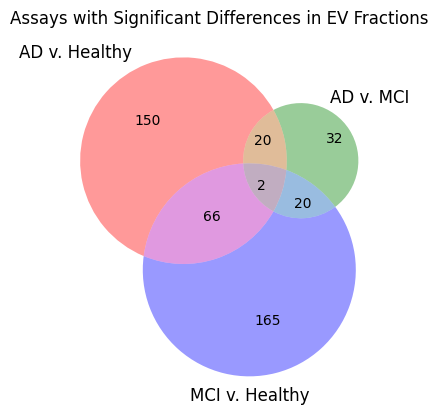

In [283]:
# Make a venn diagram of assays with significant differences in the EV fractions between sample groups
venn3(
    [
        ad_healthy_ev_sig_dif_assays,
        ad_mci_ev_sig_dif_assays,
        mci_healthy_ev_sig_dif_assays,
    ],
    set_labels=("AD v. Healthy", "AD v. MCI", "MCI v. Healthy"),
)
plt.title("Assays with Significant Differences in EV Fractions")

Text(0.5, 1.0, 'Assays with Significant Differences in Secreted Fractions')

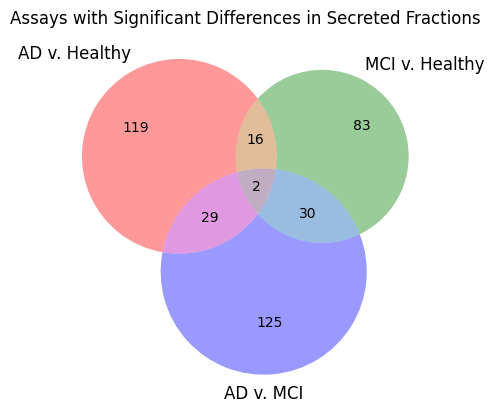

In [284]:
# Make a venn diagram of assays with significant differences in the secreted fractions between sample groups
venn3(
    [
        ad_healthy_secreted_sig_dif_assays,
        mci_healthy_secreted_sig_dif_assays,
        ad_mci_secreted_sig_dif_assays,
    ],
    set_labels=("AD v. Healthy", "MCI v. Healthy", "AD v. MCI"),
)
plt.title("Assays with Significant Differences in Secreted Fractions")

Text(0.5, 1.0, 'Assays with Significant Differences Between Sample Groups')

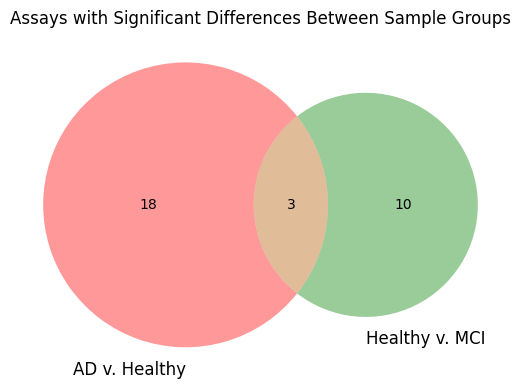

In [285]:
# Make a venn diagram of assays that have a significant difference between the sample groups
venn2(
    [
        (ad_healthy_ev_sig_dif_assays & ad_healthy_secreted_sig_dif_assays),
        (mci_healthy_ev_sig_dif_assays & mci_healthy_secreted_sig_dif_assays),
    ],
    set_labels=("AD v. Healthy", "Healthy v. MCI"),
)
plt.title("Assays with Significant Differences Between Sample Groups")

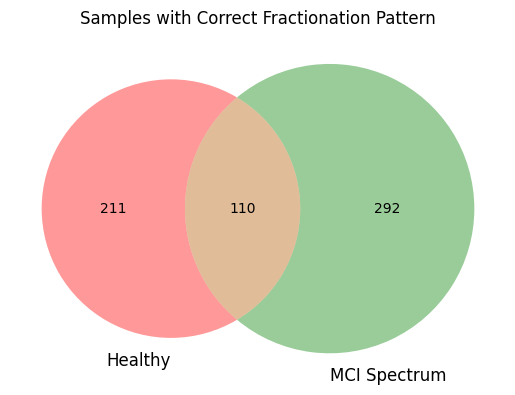

In [286]:
# Fractionation analysis comparison of healthy vs. MCI spectrum samples
healthy_ev_fractions = tidy_data[
    (
        (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
    )
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

healthy_fract6 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 6 ")
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

healthy_fract11 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 11")
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

healthy_fract12 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 12")
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

healthy_fract13 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 13")
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

mci_ev_fractions = tidy_data[
    (
        (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
    )
    & (tidy_data.index.get_level_values("Health") == "MCI")
]

mci_fract6 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 6 ")
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]

mci_fract11 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 11")
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]

mci_fract12 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 12")
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]

mci_fract13 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 13")
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]


healthy_fractionation = []
mci_fractionation = []


for assay in list(tidy_data.columns):
    if not tidy_data[assay].isna().all():
        healthy_ev_fraction_median = healthy_ev_fractions[assay].median()
        healthy_fract6_median = healthy_fract6[assay].median()
        healthy_fract11_median = healthy_fract11[assay].median()
        healthy_fract12_median = healthy_fract12[assay].median()
        healthy_fract13_median = healthy_fract13[assay].median()
        if (
            (healthy_ev_fraction_median > healthy_fract6_median)
            and (healthy_ev_fraction_median > healthy_fract11_median)
            and (healthy_ev_fraction_median > healthy_fract12_median)
            and (healthy_ev_fraction_median > healthy_fract13_median)
        ):
            healthy_fractionation.append(assay)
        mci_ev_fraction_median = mci_ev_fractions[assay].median()
        mci_fract6_median = mci_fract6[assay].median()
        mci_fract11_median = mci_fract11[assay].median()
        mci_fract12_median = mci_fract12[assay].median()
        mci_fract13_median = mci_fract13[assay].median()
        if (
            (mci_ev_fraction_median > mci_fract6_median)
            and (mci_ev_fraction_median > mci_fract11_median)
            and (mci_ev_fraction_median > mci_fract12_median)
            and (mci_ev_fraction_median > mci_fract13_median)
        ):
            mci_fractionation.append(assay)

venn2(
    [set(healthy_fractionation), set(mci_fractionation)],
    set_labels=("Healthy", "MCI Spectrum"),
)
plt.title("Samples with Correct Fractionation Pattern")
plt.show()

In [287]:
# All samples fractionation analysis
ev_fractions = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
]
fract6 = tidy_data[(tidy_data.index.get_level_values("Sample").str.contains("6"))]
fract11 = tidy_data[(tidy_data.index.get_level_values("Sample").str.contains("11"))]
fract12 = tidy_data[(tidy_data.index.get_level_values("Sample").str.contains("12"))]
fract13 = tidy_data[(tidy_data.index.get_level_values("Sample").str.contains("13"))]

correct_fractionation = []
annoying_assays = []

for assay in list(tidy_data.columns):
    if not tidy_data[assay].isna().all():
        ev_fraction_median = ev_fractions[assay].median()
        fract6_median = fract6[assay].median()
        fract11_median = fract11[assay].median()
        fract12_median = fract12[assay].median()
        fract13_median = fract13[assay].median()
        if (
            (ev_fraction_median > fract6_median)
            and (ev_fraction_median > fract11_median)
            and (ev_fraction_median > fract12_median)
            and (ev_fraction_median > fract13_median)
        ):
            correct_fractionation.append(assay)
    else: 
        annoying_assays.append(assay)

In [288]:
len(annoying_assays)

40

In [289]:
# Overlap between median assays, brain rna seq, and internal only tmhmm

# Internal microglia
internal_microglia_targets = (
    set(correct_fractionation) & set(microglia_uniprot_ids) & set(inside_uniprots)
)

# Internal astrocyte
internal_astrocyte_targets = (
    set(correct_fractionation) & set(astrocyte_uniprot_ids) & set(inside_uniprots)
)

# Internal oligodendrocyte
internal_oligodendrocyte_targets = (
    set(correct_fractionation) & set(oligodendrocyte_uniprot_ids) & set(inside_uniprots)
)

# Internal neuron
internal_neuron_targets = (
    set(correct_fractionation) & set(neuron_uniprot_ids) & set(inside_uniprots)
)

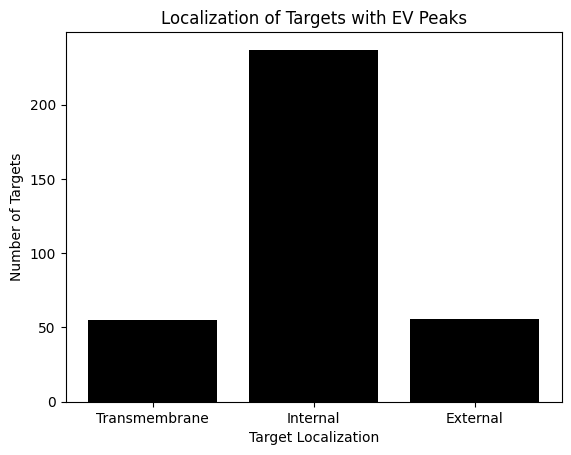

In [290]:
tm_peak = set(tm_uniprots) & set(correct_fractionation)
internal_peak = set(inside_uniprots) & set(correct_fractionation)
external_peak = set(outside_uniprots) & set(correct_fractionation)

peak_dict = {
    "Transmembrane": len(tm_peak),
    "Internal": len(internal_peak),
    "External": len(external_peak),
}

x_labels = list(peak_dict.keys())
y_labels = list(peak_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Target Localization")
plt.ylabel("Number of Targets")
plt.title("Localization of Targets with EV Peaks")
plt.show()

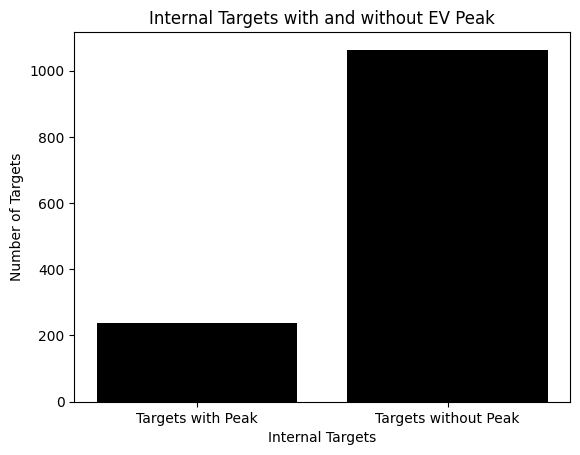

In [291]:
internal_with_peak = set(inside_uniprots) & set(correct_fractionation)
internal_without_peak = set(inside_uniprots) - set(correct_fractionation)

int_dict = {
    "Targets with Peak": len(internal_with_peak),
    "Targets without Peak": len(internal_without_peak),
}

x_labels = list(int_dict.keys())
y_labels = list(int_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Internal Targets")
plt.ylabel("Number of Targets")
plt.title("Internal Targets with and without EV Peak")
plt.show()

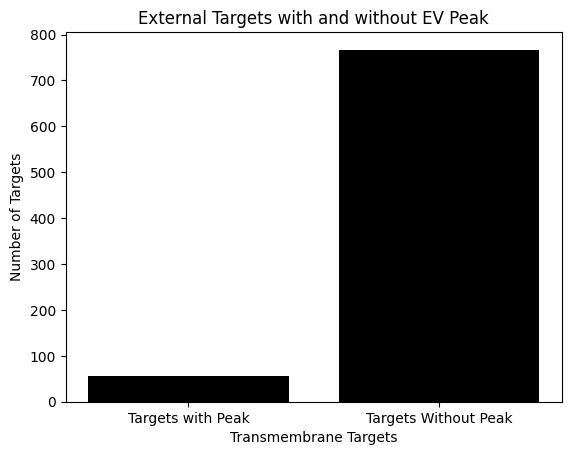

In [292]:
external_with_peak = set(outside_uniprots) & set(correct_fractionation)
external_without_peak = set(outside_uniprots) - set(correct_fractionation)

ext_dict = {
    "Targets with Peak": len(external_with_peak),
    "Targets Without Peak": len(external_without_peak),
}

x_labels = list(ext_dict.keys())
y_labels = list(ext_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Transmembrane Targets")
plt.ylabel("Number of Targets")
plt.title("External Targets with and without EV Peak")
plt.show()

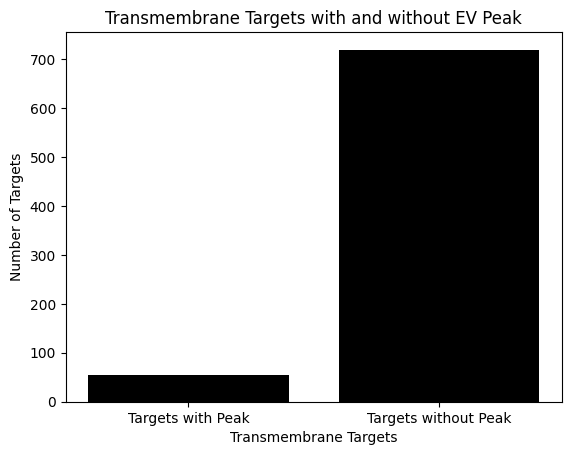

In [293]:
tm_with_peak = set(tm_uniprots) & set(correct_fractionation)
tm_without_peak = set(tm_uniprots) - set(correct_fractionation)

tm_dict = {
    "Targets with Peak": len(tm_with_peak),
    "Targets without Peak": len(tm_without_peak),
}

x_labels = list(tm_dict.keys())
y_labels = list(tm_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Transmembrane Targets")
plt.ylabel("Number of Targets")
plt.title("Transmembrane Targets with and without EV Peak")
plt.show()

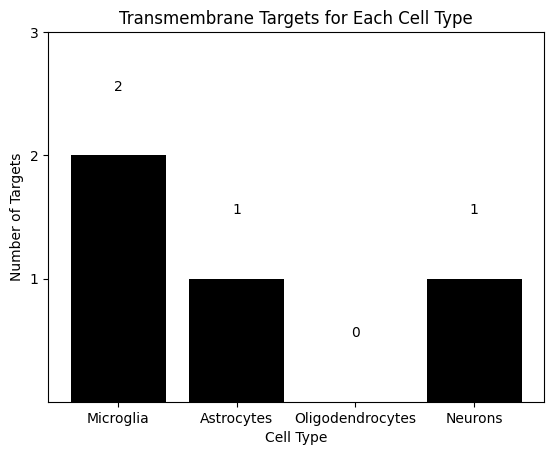

In [299]:
# Overlap between median assays, brain rna seq, and transmembrane targets

# TM microglia
tm_microglia_targets = (
    set(correct_fractionation) & set(microglia_uniprot_ids) & set(tm_uniprots)
)

# TM astrocyte
tm_astrocyte_targets = (
    set(correct_fractionation) & set(astrocyte_uniprot_ids) & set(tm_uniprots)
)

# TM oligodendrocyte
tm_oligodendrocyte_targets = (
    set(correct_fractionation) & set(oligodendrocyte_uniprot_ids) & set(tm_uniprots)
)

# TM neuron
tm_neuron_targets = (
    set(correct_fractionation) & set(neuron_uniprot_ids) & set(tm_uniprots)
)

# number of transmembrane targets per cell type

internal_dict = {
    "Microglia": len(tm_microglia_targets),
    "Astrocytes": len(tm_astrocyte_targets),
    "Oligodendrocytes": len(tm_oligodendrocyte_targets),
    "Neurons": len(tm_neuron_targets),
}

x_labels = list(internal_dict.keys())
y_labels = list(internal_dict.values())

plt.bar(x_labels, y_labels, color="black")

for i, v in enumerate(y_labels):
    plt.text(i, v + 0.5, str(v), ha="center", va="bottom")

plt.yticks([1, 2, 3])

plt.xlabel("Cell Type")
plt.ylabel("Number of Targets")
plt.title("Transmembrane Targets for Each Cell Type")
plt.show()

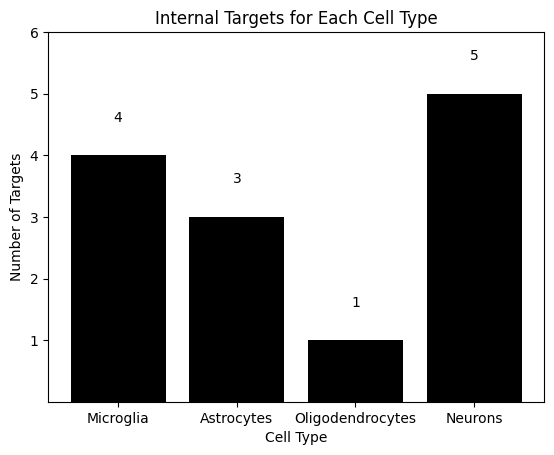

In [300]:
internal_dict = {
    "Microglia": len(internal_microglia_targets),
    "Astrocytes": len(internal_astrocyte_targets),
    "Oligodendrocytes": len(internal_oligodendrocyte_targets),
    "Neurons": len(internal_neuron_targets),
}

x_labels = list(internal_dict.keys())
y_labels = list(internal_dict.values())

plt.bar(x_labels, y_labels, color="black")

for i, v in enumerate(y_labels):
    plt.text(i, v + 0.5, str(v), ha="center", va="bottom")

plt.yticks([1, 2, 3, 4, 5, 6])

plt.xlabel("Cell Type")
plt.ylabel("Number of Targets")
plt.title("Internal Targets for Each Cell Type")
plt.show()

In [296]:
def graph_medians(uniprot_id):
    df = tidy_data[uniprot_id]
    df = df.reset_index(level=["SampleID", "Health", "Sample"])

    df["Sample"] = pd.Categorical(df["Sample"], categories=CSF_SAMPLES, ordered=True)

    df_sorted = df.sort_values("Sample")

    grouped_data = [
        group[uniprot_id].values for name, group in df_sorted.groupby("Sample")
    ]

    plt.boxplot(grouped_data, notch=None, vert=None, patch_artist=None, widths=None)

    plt.xlabel("Sample Description")

    plt.ylabel("Delta")

    plt.title(f"{uniprot_id} Fractionation Pattern")

    plt.xticks(range(1, len(CSF_SAMPLES) + 1), CSF_SAMPLES)

    plt.xticks(rotation=45, ha="right")

    plt.show()

In [297]:
tm_oligodendrocyte_targets

set()

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_9232\2055375813.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group[uniprot_id].values for name, group in df_sorted.groupby("Sample")


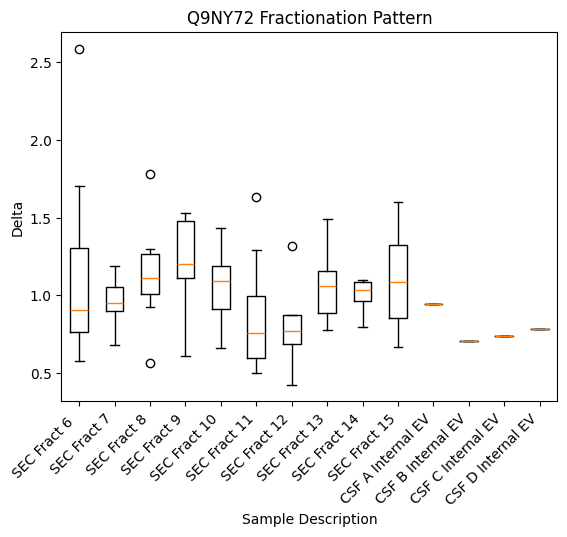

In [298]:
graph_medians("Q9NY72")